# EE782: AML Project
# IITB SmartBot

Dhatri Mehta 210070027</br>
Devesh Soni 21D070025</br>
Shivansh Gupta 21D070067

## Packages and Libraries

In [ ]:
## This was just to check the status and usage of compute unit of GPU
!nvidia-smi

Thu Nov 30 10:32:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# This code installs specific versions of various Python packages using pip, suppressing progress bars for a cleaner output

!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchvision 0.16.0+cu118 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.20 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.


Binary wheel files in Python are pre-built distributions of a package that can be easily installed on a compatible system without the need for compilation. They play a crucial role in simplifying the installation process and improving the efficiency of package distribution. For our model we are downloading a AUTOGPTQ BWF file package

In [ ]:
#using the wget command to download a binary wheel file
#The file being downloaded is "auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl,"  related to a AutoGPTQ model

!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl

In [ ]:
!pip install -qqq auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl --progress-bar off

In [ ]:
!apt-get update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
## importing various libraries required for our LLM
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data

### The below code show how our pdf looks like

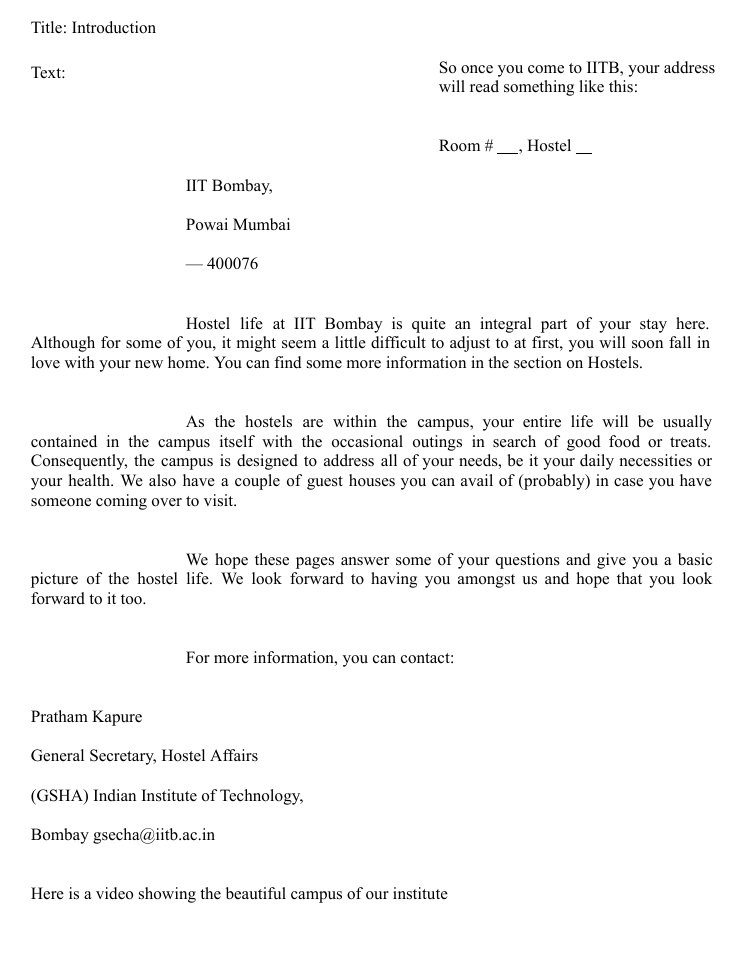

In [ ]:
scraped_data_images = convert_from_path("/content/Scraped_data/Final_data.pdf", dpi=88)
scraped_data_images[0]

In [ ]:
!rm -rf "db"

In [ ]:
## loading the pdf file
loader = PyPDFDirectoryLoader("/content/Scraped_data")
docs = loader.load()
len(docs)                        # number of pages in the pdf

82

In [ ]:
##  this code is setting up an embedding generator using the Hugging Face "instructor-large" model
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

load INSTRUCTOR_Transformer
max_seq_length  512


This code is using a recursive character-based text splitter to divide a collection of documents into smaller chunks of text
One chunk contains 1024 words and each chunk has an overlap of 64 words with successive and predecessor chunk. This help to form a proper connection between differnet chunks helping the model to learn efficiently.

In [ ]:
# this code is using a recursive character-based text splitter to divide a collection of documents into smaller chunks of text

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

164

**Chroma** is an open-source embedding database that is used to store and manage embeddings. </br>
This code creates a Chroma object by calling the from_documents method. The method takes texts (a list of text chunks created above), embeddings (hkunlp/HuggingFace), and persist_directory="db"

In [ ]:
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

## Llama 2 13B

This code snippet is initializing a language model using the Hugging Face Transformers library</br>
The pre-trained language model we are using is **TheBloke/Llama-2**-13B-chat-GPTQ.</br>
The model variable now holds an instance of the **GPTQ language model** ready for use for our Q&A tasks.

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

#  initializes a tokenizer using the AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

# This initializes the GPTQ (Quantized GPT) language model using the AutoGPTQForCausalLM class
# The from_quantized method is used to load a quantized version of the model, which we have downloaded above as a binary wheel file
model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

In [ ]:
## This was just to check the status and usage of compute unit of GPU
!nvidia-smi

Thu Nov 30 10:37:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    37W /  70W |   9593MiB / 15360MiB |     60%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

This is **System Prompt** structure which we have designed for use in a context to guide the behavior of our language model with specific instructions while taking into account user prompts.

In [ ]:

DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()

def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} [/INST]
""".strip()

The **TextStreamer** class is a utility class from the transformers library that is used to stream the output of a language model during generation. This can be useful for applications where you want to display the generated text as it is being produced, or for collecting the output of the model without waiting for the entire generation to finish.

In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [ ]:
## This code is creating a text generation pipeline
text_pipeline = pipeline(
    "text-generation",
    model=model,                                                        # pre-trained language model to be used for text generation
    tokenizer=tokenizer,                                                # tokenizer defined above
    max_new_tokens=1024,                                                # Sets the maximum number of tokens that can be generated as output
    temperature=0,                                                      # Temperature is a hyperparameter that controls the randomness of the generated text.
                                                                           # A temperature of 0 results in deterministic output, meaning the most likely token is always chosen.
    top_p=0.95,                                                         # controls the diversity of the generated output
    repetition_penalty=1.15,                                            # Repetition penalty discourages the model from repeating the same tokens in its output
    streamer=streamer,
)


    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.1.0+cu121)
    Python  3.10.11 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'Marian

In [ ]:
# creating an instance of the HuggingFacePipeline class, for a pipeline for text generation (text_pipeline) created above
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [ ]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
# This code is creating a RetrievalQA object named qa_chain using the question-answering pipeline (llm)
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

## Chat with our SmartBOT

In [ ]:
result = qa_chain("hello how are you")

 Hello! I'm doing well, thank you for asking. However, I would like to point out that the question is a bit ambiguous and open-ended. Could you please provide more context or clarify what you mean by "hello how are you"? I want to make sure I give you an accurate and helpful response.


In [ ]:
result = qa_chain("I have some questions, can I ask you?")

 Sure! I'll do my best to help answer your questions. What are your questions?


In [ ]:
result = qa_chain("What is SMP?")

 Based on the given context, I can answer the following question:

What is SMP?

SMP stands for Student Mentor Programme, which is a program within IIT Bombay that aims to provide constructive and positive interaction, guidance, and mentorship to junior students by senior students. The primary objective of SMP is to motivate students to excel in both academic and non-academic fields and make the most of their life at IIT Bombay.


In [ ]:
result = qa_chain("How can I book a room in guest house?")

 Based on the provided information, here is the answer to your question:

To book a room in the Guest House, you can obtain a booking form from the Hostel Coordinating Unit (HCU) located in the Main Building (MB). You may also email hcu.office@iitb.ac.in to request a form. Once you have filled out the form and obtained approval, take the approved form to the Hall Manager of the allotted hostel and collect the key from their office. In emergency situations, guests can stay in the hostel rooms after entry in the Guest Register kept with the security at the hostel entrance. The formalities can be completed on the next working day.


In [ ]:
result = qa_chain("What are the different scholarships provided at iit Bomaby?")

 Based on the information provided, there are two types of scholarships available at IIT Bombay:

1. Merit cum Means Scholarship: This scholarship is based on both merit (JEE AIR and UCEED rank for B.Tech and B.Des students respectively) and means (parental income). Students whose parents' annual gross income does not exceed Rs. 5,00,000/ are eligible to apply.
2. IT Support Scholarship: This scholarship is a financial support scheme for economically weak students, which covers tuition fees, mess advance, and other expenses. It is offered by the Director of IIT Bombay in collaboration with generous alumni of IIT Bombay and the Dean of the ACR office. The scholarship is awarded based on academic performance, and if a student's performance is poor, the Dean may cancel the scholarship.

There is also an AP Financial Aid Programme* with a 0% interest rate, offered by Tata Motors for UGs and PGs whose annual family income falls below 6.5 lakh per annum, provided the student has a CPI > 6. T

In [ ]:
result = qa_chain("How can I calculate CPI and SPI?")

 Based on the given context, I can answer the following questions:

1. How to calculate SPI (Semester Performance Index):
To calculate SPI, we need to multiply the credit points earned in each course by the grade points obtained in that course, and then divide the total credit points earned by the total credits taken.

Formula: SPI = (C1 x G1 + C2 x G2 + C3 x G3 + C4 x G4) / (C1 + C2 + C3 + C4)

Where:

* C1, C2, C3, and C4 are the credits earned in each course.
* G1, G2, G3, and G4 are the grade points obtained in each course.
2. How to calculate CPI (Cumulative Performance Index):
To calculate CPI, we need to multiply the SPI for each semester by the number of credits taken in that semester, and then divide the total CPI by the total credits taken.

Formula: CPI = (SPI1 x Credits in Semester 1 + SPI2 x Credits in Semester 2 + ...) / (Total Credits)

Where:

* SPI1 and SPI2 are the SPI values for each semester.
* Credits in Semester 1 and Credits in Semester 2 are the number of credit

In [ ]:
result = qa_chain("what is Mood Indigo and what all should I need to know to attend it?")

 Based on the given context, here are the answers to your questions:

1. What is Mood Indigo?
Mood Indigo is a college festival that offers exposure, mentorship, network, funding opportunities, and wisdom to turn dreams into reality for college students.
2. What all should I need to know to attend Mood Indigo?
To attend Mood Indigo, you will need to have an MI number, which you can obtain by registering on the website. You will also need a college ID to participate in certain activities or competitions. The entry to the festival is free for all college students. The artist lineup for Mood Indigo 2022 has not been announced yet, but you can stay tuned to their official page for updates. After completing the registration, you should note down your unique MI number, as it will be used to identify yourself while attending the festival.


In [ ]:
result = qa_chain("When is Mood Indigo?")

 Based on the information provided, Mood Indigo will be held from December 18th to December 21st, 2023.


In [ ]:
result = qa_chain(
    "what is Semester Excahnge?"
)

 Based on the provided text, I can answer the following question:

What is Semester Exchange?

According to the text, Semester Exchange is a program offered by IIT Bombay that allows students to study abroad at partner universities across the globe while still being a student at IIT Bombay. Students can spend up to two semesters abroad, taking courses that they would otherwise have to finish at IIT Bombay. The institute has partnerships with numerous universities, and students do not need to pay tuition fees at the foreign university. Additionally, students can explore a wide range of courses that would otherwise be inaccessible, and engaging in research projects expands their knowledge base.


In [ ]:
result = qa_chain("Who is GSHA and can you provide his contact?")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 Based on the provided context, GSHA stands for General Secretary of Hostel Affairs at Indian Institute of Technology Bombay (IITB). The name of the person holding this position is Pratham Kapure. His contact information is gsecha@iitb.ac.in.


In [ ]:
result = qa_chain("I'm hungry, Where can I get a pizza?")

 Based on the information provided, there are several options for getting a pizza near IIT Bombay. Here are a few suggestions:

1. Dominos: Located in SAC Parking lot, Dominos offers exotic and spicy pizzas with free delivery on campus. You can expect a cheese burst pizza in no more than 30 minutes. Phone: 1800 208 1234. Menu link: m.dominos.co.in
2. KFC: Located in the Galleria food court, KFC is one of the many options available for eating out when on a budget. They offer a variety of menu items, including pizzas.
3. Pizza Hut: Also located in the Galleria food court, Pizza Hut is another option for pizza lovers. They offer a range of pizza varieties and other menu items.
4. Papa Johns: Located in the same area as KFC and Pizza Hut, Papa Johns is another popular choice for pizza. They offer a variety of pizza options and free delivery on orders above a certain amount.

Please note that these options are based on the information provided and may not be comprehensive or up-to-date. It'

## References


https://huggingface.co/TheBloke/Llama-2-13B-chat-GPTQ </br>
https://huggingface.co/hkunlp/instructor-large </br>
https://www.mlexpert.io/prompt-engineering/private-gpt4all#create-chain

